In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_excel("PetrolConsumptionGDPReal.xlsx", sheet_name="Sheet1")

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

# Display basic information about the dataset
print("\nDataset Info:")
print(data.info())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

First 5 rows of the dataset:
   date  Actual MS 1980-2023       Real GDP
0  1980             542254.0  204617.825536
1  1981             589017.0  217716.910084
2  1982             644907.0  219620.869640
3  1983             690214.0  195215.358025
4  1984             754725.0  190998.787568

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 59 non-null     int64  
 1   Actual MS 1980-2023  44 non-null     float64
 2   Real GDP             59 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.5 KB
None

Missing Values:
date                    0
Actual MS 1980-2023    15
Real GDP                0
dtype: int64


In [3]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y')

# Create temporal features
def create_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    return df

# Apply feature engineering
data = create_features(data)

# Display the updated dataset with new features
print("\nDataset after feature engineering:")
print(data.head())


Dataset after feature engineering:
        date  Actual MS 1980-2023       Real GDP  year  month  day  \
0 1980-01-01             542254.0  204617.825536  1980      1    1   
1 1981-01-01             589017.0  217716.910084  1981      1    1   
2 1982-01-01             644907.0  219620.869640  1982      1    1   
3 1983-01-01             690214.0  195215.358025  1983      1    1   
4 1984-01-01             754725.0  190998.787568  1984      1    1   

   day_of_year  week_of_year  quarter  
0            1             1        1  
1            1             1        1  
2            1            53        1  
3            1            52        1  
4            1            52        1  


In [4]:
# Define features and target variable
features = ['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'Real GDP']
target = 'Actual MS 1980-2023'

In [5]:
def train_and_forecast(data, forecast_years, output_file):
    # Separate known and unknown data
    known_data = data[data[target].notna()]
    unknown_data = data[data[target].isna()]

    # Filter unknown data for the specified forecast years
    unknown_data = unknown_data[unknown_data['year'].isin(forecast_years)]

    # Prepare the training and testing data
    X = known_data[features]
    y = known_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Hyperparameter tuning with Grid Search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.5, 0.7, 1.0]
    }

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Use the best model
    best_model = grid_search.best_estimator_

    # Evaluate the model
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("\nModel Evaluation Metrics:")
    print(f"MSE: {mse}, \nMAE: {mae}, \nMAPE: {mape}, \nRMSE: {rmse}")

    # Forecast for the specified years
    X_unknown = unknown_data[features]
    forecasted_values = best_model.predict(X_unknown)
    unknown_data[target] = forecasted_values

    # Combine known and forecasted data
    final_data = pd.concat([known_data, unknown_data]).sort_values(by='date')

    # Save the final dataset
    final_data.to_excel(output_file, index=False)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(final_data['date'], final_data[target], label='Historical Data', marker='o', color='blue')
    plt.plot(unknown_data['date'], unknown_data[target], label='Forecasted Data', marker='x', linestyle='--', color='red')
    plt.xlabel('Year')
    plt.ylabel('Crude Oil Consumption')
    plt.title(f'Historical and Forecasted Crude Oil Consumption (1980-{forecast_years[-1]})')
    plt.legend()
    plt.grid()
    plt.show()

    return final_data

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Model Evaluation Metrics:
MSE: 597198624101.5751, MAE: 456544.6458333333, MAPE: 0.10901952122999493, RMSE: 772786.2732357343


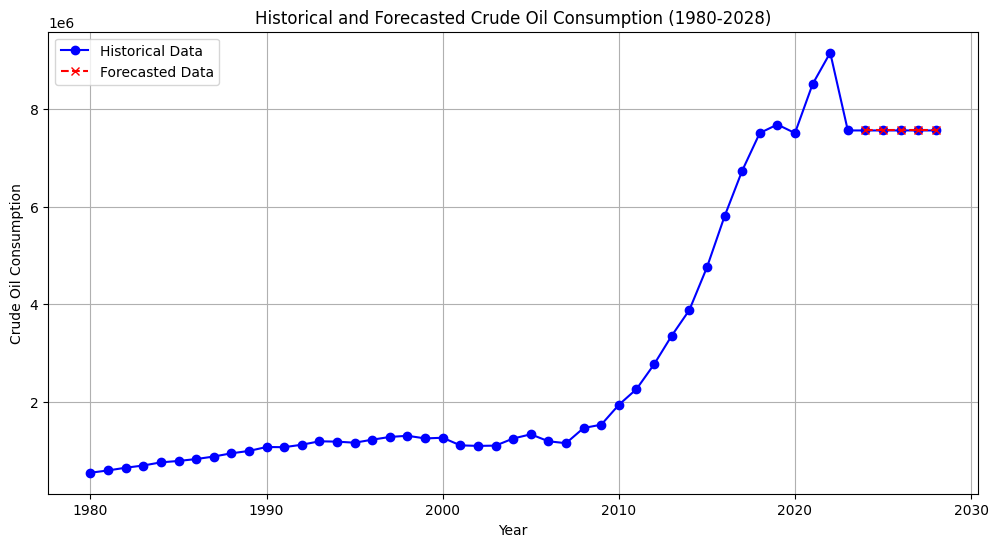

In [6]:
# Forecast for 2024–2028
forecast_years = [2024, 2025, 2026, 2027, 2028]
output_file = "Forecasted_Petrol_Consumption_2024_2028.xlsx"
data = train_and_forecast(data, forecast_years, output_file)

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Model Evaluation Metrics:
MSE: 12886259235.417187, MAE: 69925.5625, MAPE: 0.045411336733035636, RMSE: 113517.66045605937


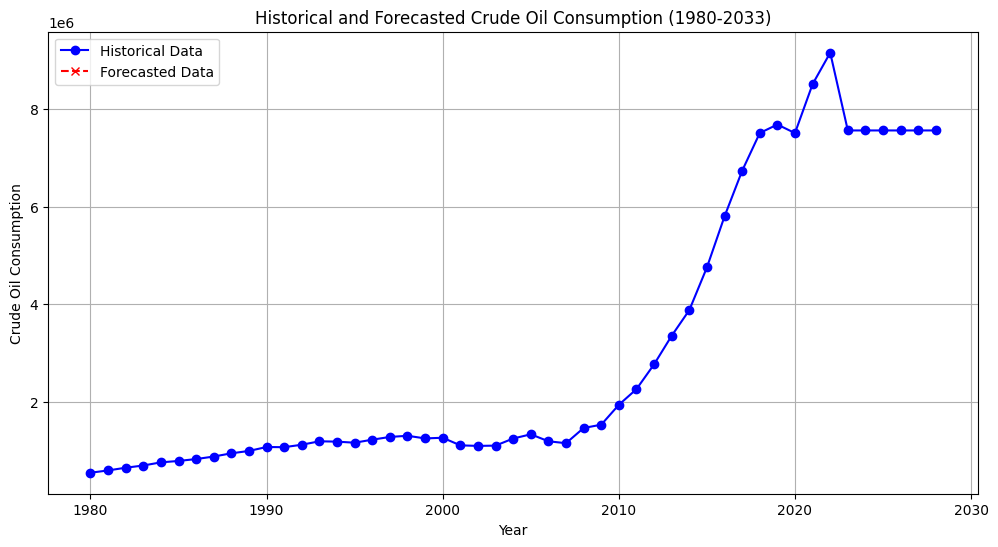

In [7]:
# Load the updated dataset
data = pd.read_excel("Forecasted_Petrol_Consumption_2024_2028.xlsx")

# Forecast for 2029–2033
forecast_years = [2029, 2030, 2031, 2032, 2033]
output_file = "Forecasted_Petrol_Consumption_2029_2033.xlsx"
data = train_and_forecast(data, forecast_years, output_file)

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Model Evaluation Metrics:
MSE: 12886259235.417187, MAE: 69925.5625, MAPE: 0.045411336733035636, RMSE: 113517.66045605937


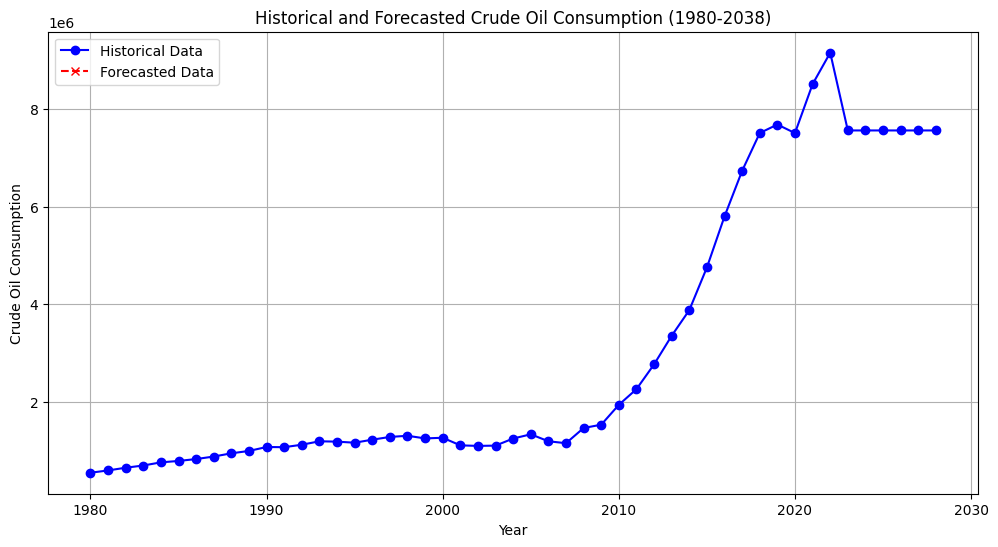

In [8]:
# Load the updated dataset
data = pd.read_excel("Forecasted_Petrol_Consumption_2029_2033.xlsx")

# Forecast for 2034–2038
forecast_years = [2034, 2035, 2036, 2037, 2038]
output_file = "Forecasted_Petrol_Consumption_2034_2038.xlsx"
data = train_and_forecast(data, forecast_years, output_file)